# Ridge-training-based auxiliary analysis of line attractor creation

Here we use the dual ridge-training protocol to explore how a line attractor could be built up out of a sequence of added support states.

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge


from aux import get_flow
from kernels import make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 21)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

# ker_vmap = vmap(ker, (0, None), 0)  # takes (xs, y)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], np.zeros(D), x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

In [3]:
def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r')
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r')
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r')
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs

In [4]:
def train(data, x_stars, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

## Many fixed points/support states

In [5]:
x_stars = np.array([
    np.linspace(-1.5, 1.5, 31),
    np.ones(31),
]).T

xs = x_stars.copy() 

v = np.array([0. ,0])
vs = np.tile(v, (len(xs), 1))
u = np.array([0., 0])
us = np.tile(u, (len(xs), 1))

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-30

alphas = train(data, x_stars, lam)
# alphas[:, 1] = 0

irnd = np.random.permutation(len(x_stars))
x_stars = x_stars[irnd, :]
alphas = alphas[irnd, :]

# simulated trajecs from initial conditions
t = np.arange(0, .5, .001)
x_inits = [np.array([-1., 1]), np.array([-.23, 1.]), np.array([.01, 1.]), np.array([.25, 1.]), np.array([1., 1.])]
xs_all = [smlt_trj(x_stars, alphas, x_init, t) for x_init in x_inits]

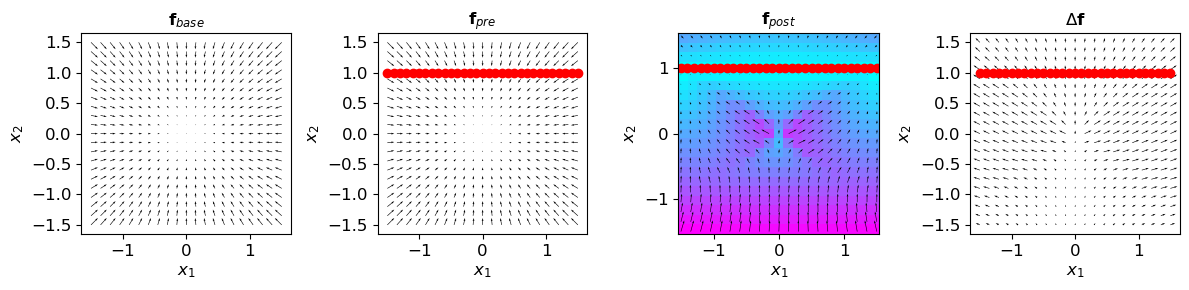

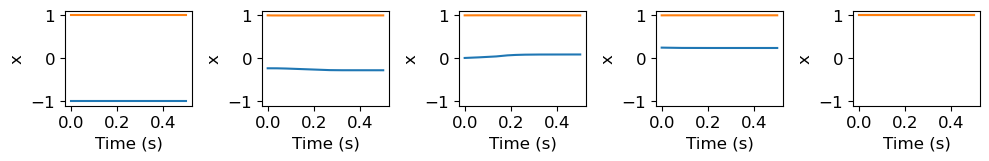

In [6]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=0, u=None)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
flow_post = get_flow(F_POST, RX, u=None)
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

fig, axs = plt.subplots(1, 5, figsize=(10, 1.7), tight_layout=True)
for ax, xs in zip(axs, xs_all):
    ax.plot(t, xs)
    set_plot(ax, y_lim=(-1.1, 1.1), x_label='Time (s)', y_label='x')

In [7]:
## simulation params
DT = .001
t = np.arange(0, .5, DT)

T_CUE = .1
IT_CUE = int(round(T_CUE//DT))
LAM_CUE = .02/DT

## base system params
TAU = .01
B = np.eye(D)
C = np.eye(D)

## cues
us_cue = np.zeros((len(t), D))
us_cue[IT_CUE, 1] = LAM_CUE

LAM = 1000000000000

DT = .001

T_START = 0.01
IT_START = int(T_START//DT)

T_HOLD = 0.05
IT_HOLD = int(T_HOLD//DT)

T_PAUSE = .01
IT_PAUSE = int(T_PAUSE//DT)

# create learning input and signals
t_learn = np.arange(0, (len(x_stars)+1)*(T_HOLD+T_PAUSE), DT)
us_learn = np.zeros((len(t_learn), D))
ls_learn = np.zeros((len(t_learn), D))

it_temp = IT_START

for cx_star, (x_star, alpha) in enumerate(zip(x_stars, alphas)):
    us_learn[it_temp:it_temp+IT_HOLD, :] = LAM*x_star
    ls_learn[it_temp+IT_HOLD-1, :] = 1/DT*alpha

    it_temp += (IT_HOLD + IT_PAUSE)

# pre-learning
W = np.zeros((N, D))
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = np.zeros(D)

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_cue[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx

# learning
xs = np.nan*np.zeros((len(t_learn), D))
xs[0, :] = np.zeros(D)

ls = ls_learn.copy()

for ct, t_ in enumerate(t_learn[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_learn[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
    # implement plasticity rule
    if np.linalg.norm(ls[ct]) > 0:
        for d in range(D):
            W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))

# post-learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = np.zeros(D)

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_cue[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx

In [8]:
# primal system
df_onl = lambda x: C@W.T@psi(x)
F_onl = lambda x, u: (1/TAU)*(-x + df_onl(x) + B@u)

flow_onl = get_flow(F_onl, RX)

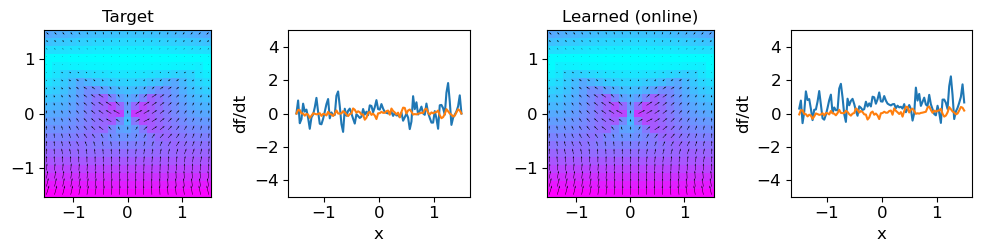

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), tight_layout=True)

flow_targ = flow_post
axs[0].matshow(np.linalg.norm(flow_targ, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[0], flow_targ, RX)
axs[0].set_aspect('equal')
axs[0].xaxis.tick_bottom()
set_plot(axs[0], title='Target', font_size=10)

x_temp = np.linspace(-1.5, 1.5, 100)
dxdt_targ = [F_POST(np.array([x_temp_, 1]), np.zeros(D)) for x_temp_ in x_temp]
axs[1].plot(x_temp, dxdt_targ)
set_plot(axs[1], x_label='x', y_label='df/dt')

axs[2].matshow(np.linalg.norm(flow_onl, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[2], flow_onl, RX)
axs[2].set_aspect('equal')
axs[2].xaxis.tick_bottom()
set_plot(axs[2], title='Learned (online)', font_size=10)

for ax in [axs[0], axs[2]]:
    set_plot(ax, x_lim=(RX[0]-DX/2, RX[-1]+DX/2), y_lim=(RX[0]-DX/2, RX[-1]+DX/2))
    
dxdt_onl = [F_onl(np.array([x_temp_, 1]), np.zeros(D)) for x_temp_ in x_temp]
axs[3].plot(x_temp, dxdt_onl)
set_plot(axs[3], x_label='x', y_label='df/dt')

for ax in [axs[1], axs[3]]:
    set_plot(ax, y_lim=(-5, 5))

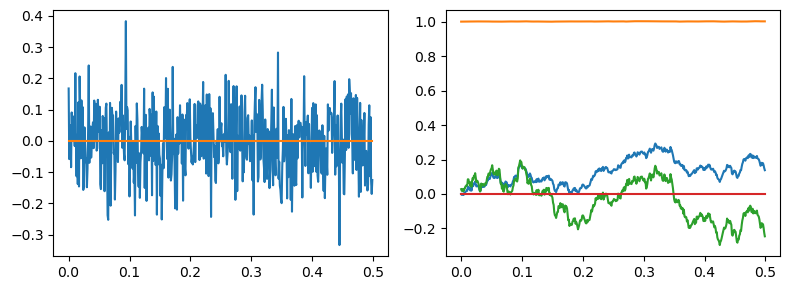

In [10]:
# run simulation
u_test = .1*np.array([np.random.randn(len(t)), np.zeros(len(t))]).T

xs = np.nan*np.zeros((len(t), D))
xs[0, :] = np.array([0, 1.])

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = DT*F_onl(xs[ct-1, :], u_test[ct, :])
    # dx = DT*F_POST(xs[ct-1, :], u_test[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx

fig, axs = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
axs[0].plot(t, u_test)
axs[1].plot(t, xs)
axs[1].plot(t, u_test.cumsum(axis=0)/6)